In [12]:
from sklearn.metrics.pairwise import polynomial_kernel,rbf_kernel
import numpy as np
import glob
import pickle as pk
from sklearn.preprocessing import MinMaxScaler,StandardScaler,PolynomialFeatures
import sys
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

In [3]:
### loadiing entire data-set

# Background

b_name='/home/thiago/Documents/Data_Sets/LPC-anomaly-detection/Input_Background_1.csv'
background = np.genfromtxt(b_name, delimiter=',')
background = background[1:,:]
print(".Background Loaded..." )
print(".Background shape: {}".format(background.shape))

# Signal

s_name='/home/thiago/Documents/Data_Sets/LPC-anomaly-detection/Input_Signal_1.csv'
signal = np.genfromtxt(s_name, delimiter=',')
signal = signal[1:,:]
print(".Signal Loaded...")
print(".Signal shape: {}\n".format(signal.shape))

.Background Loaded...
.Background shape: (543500, 21)
.Signal Loaded...
.Signal shape: (522467, 21)



In [4]:
### reducing events number

# Number of events
total = 200000

# Percentage of background samples on the testing phase
background_percent = 0.50

# Percentage of background samples to divide the data-set

dat_set_percent = total/len(background)


# Reducing background samples

_,background_train = train_test_split(background, test_size=dat_set_percent)


# Iserting the correct number of signal in training

n_signal_samples = int(len(background_train)*(1-background_percent))

_,background_train = train_test_split(background_train, test_size=background_percent)

_,signal_train= train_test_split(signal, test_size=n_signal_samples/len(signal))


# Concatenating Signal and the Background sub-sets

data = np.vstack((background_train,signal_train))

# Creating target

y = np.ones(len(data))

y[:len(background_train)] = 0

print('\n      ==== Pre-processing Complete ====\n')
print(".Train data shape: {}".format(data.shape))
print(".Test data shape: {}".format(background_train.shape))
print(".Test Background shape: {}".format(signal_train.shape))
print('=*='*17 )



      ==== Pre-processing Complete ====

.Train data shape: (200000, 21)
.Test data shape: (100000, 21)
.Test Background shape: (100000, 21)
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=


In [5]:
### normalizing data

scaler = MinMaxScaler()

scaler.fit(data)

data = scaler.transform(data)


In [13]:
### computing pairwise metrrics

pairwise = []

# getting number of divisions

n_elements = len(signal_train)

print('Calculating pairwise metrics...')

for i in range(len(signal_train)):

    # Compute the polynomial kernel

    line = signal_train[i,18]

    aux = polynomial_kernel(line.reshape(1,-1),data[:,18].reshape(-1,1))


    # compute the distance mean and std between background and signal samples

    background_mean_dist = np.mean(aux[0,y==0])

    background_std_dist = np.std(aux[0,y==0])

    signal_mean_dist = np.mean(aux[0,y==1])

    signal_std_dist = np.std(aux[0,y==1])

    result = np.array([background_mean_dist,
                    background_std_dist,
                    signal_mean_dist,
                    signal_std_dist])

    pairwise.append(result)

    # updating progress bar

    percent = (i+1)/n_elements * 100

    info = '{:.2f}% - {:d} of {:d}'.format(percent,(i+1),n_elements)

    formated_bar = '-'*int(percent) + ' '*int(100-percent)

    if i < (n_elements):
        sys.stdout.write("\r")

    sys.stdout.write('[%s] %s' % (formated_bar,info))
    sys.stdout.flush()

Calculating pairwise metrics...


ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 21 while Y.shape[1] == 1

In [7]:
pairwise = np.array(pairwise)

pairwise.shape

(100000, 4)

In [8]:
attributes = ['background mean',
            'background std',
            'signal mean',
            'signal std']

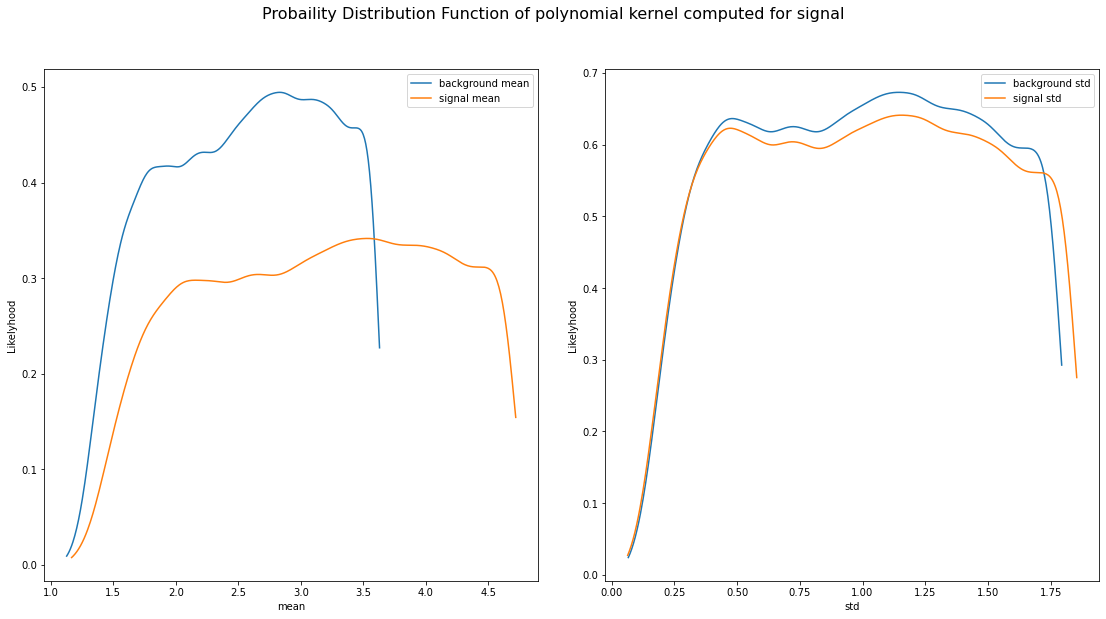

In [11]:
size_scaler = 1

fig = plt.figure(figsize= (16 * size_scaler, 9 * size_scaler))

ax = fig.subplots(1,2)

fig.suptitle('Probaility Distribution Function of polynomial kernel computed for signal', fontsize=16)

for i,att in enumerate(attributes):

        # getting attributes values

        att_background = pairwise[:,i]

        att_signal = pairwise[:,i]


        # computing the attribute distribution

        bg_kernel = stats.gaussian_kde(att_background)

        sg_kernel = stats.gaussian_kde(att_signal)


        # defining attributes limits

        bg_max = max(att_background)

        bg_min = min(att_background)

        sg_max = max(att_signal)

        sg_min = min(att_signal)


        # creating values interval for time optimization

        bg_eval = np.linspace(bg_min,bg_max,num=500)

        sg_eval = np.linspace(sg_min,sg_max,num=500)


        # calculating the likelyhood with kde kernel

        bg_likelyhood = bg_kernel(bg_eval)

        sg_likelyhood = sg_kernel(sg_eval)


        # defining plot locationg

        col = int(i%2)

        # defining label

        if col == 0: x_label = 'mean'

        else: x_label = 'std'

        # ploting results

        ax[col].plot(bg_eval, bg_likelyhood, 
                ms=3.5, linestyle='-',
                label= att)

        ax[col].legend()
        ax[col].set_xlabel(x_label)
        ax[col].set_ylabel("Likelyhood")
        ax[col].grid()


fig.tight_layout(pad=3.0)

plt.savefig('figures/polynomial-kernel-centrality-PDF.pdf',format='pdf')

del fig